In [111]:
# 2D section inversion

%matplotlib notebook

In [112]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

In [113]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
dip = np.array([0, 90])

Hreceivers = [offsets, offsets*0, 0, 0, 0]
Vreceivers = [offsets, offsets*0, 0, 0, 90]

# Source geometry

Hsource = [0, 0, 0 ,0 , 0]
Vsource = [0, 0, 0, 0, 90]

# Frequency

freq = 9000

In [114]:
class EMforward(pg.Modelling):
    
    def __init__(self):
        """Initialize the model."""
        super().__init__()
        
    def response(self, x):
        
        surface = np.array([0])
        thkx = np.array(x[0:2])
        depthx = np.hstack((surface, thkx[0], thkx[0]+thkx[1]))
        res_ground = np.array(x[2:])
        res_air = np.array([2e14])
        resx = np.hstack((res_air, res_ground))
        HCP = empymod.loop(Hsource, Hreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        VCP = empymod.loop(Vsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        PRP = empymod.loop(Hsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        Z = np.hstack((HCP.real, HCP.imag, VCP.real, VCP.imag, PRP.real, PRP.real))
        return Z
        
    def createStartModel(self, dataVals):
        
        thk_ini = [3, 4]
        res_ini = [12, 15, 18]
        x0 = thk_ini + res_ini
        return np.array(x0)

In [115]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 20 # number of sampling positions
res = np.ones((npos, nlayer))*[10,20,10]
x = np.linspace(0, 20, npos)[:,None]
thk1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
thk2 = 2 + np.sin(x*np.pi*2) # wave
depthmax = 10
ny = 50

# Arrays for plotting
y = np.linspace(0, depthmax, ny)
xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot


In [116]:
def PlotResistivities(thk1, thk2, res, npos, ny, Model):
    surface = np.zeros(npos)
    depth = np.zeros((npos,4))

    # Depths to be plotted
    for i in range(npos):
        depth[i,0] = 0
        depth[i,1] = thk1[i]
        depth[i,2] = thk1[i] + thk2[i]
        depth[i,3] = thk1[i] + thk2[i]
        
    resy = np.zeros((npos, ny))

    # Resistivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            resy[i, y1] = res[i, 0]
            y1 += 1
            y2=y1
        while y[y2] <= depth[i, 2]:
            resy[i, y2] = res[i, 1]
            y2 += 1
            if y2 == 50:
                break
        resy[i, y2:] = res[i, 2]
        
    fig, ax = plt.subplots()
    pos = ax.imshow(resy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin=10, vmax=20)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Resistivity [Ohm . m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Model)
        
    return depth, resy

<IPython.core.display.Javascript object>


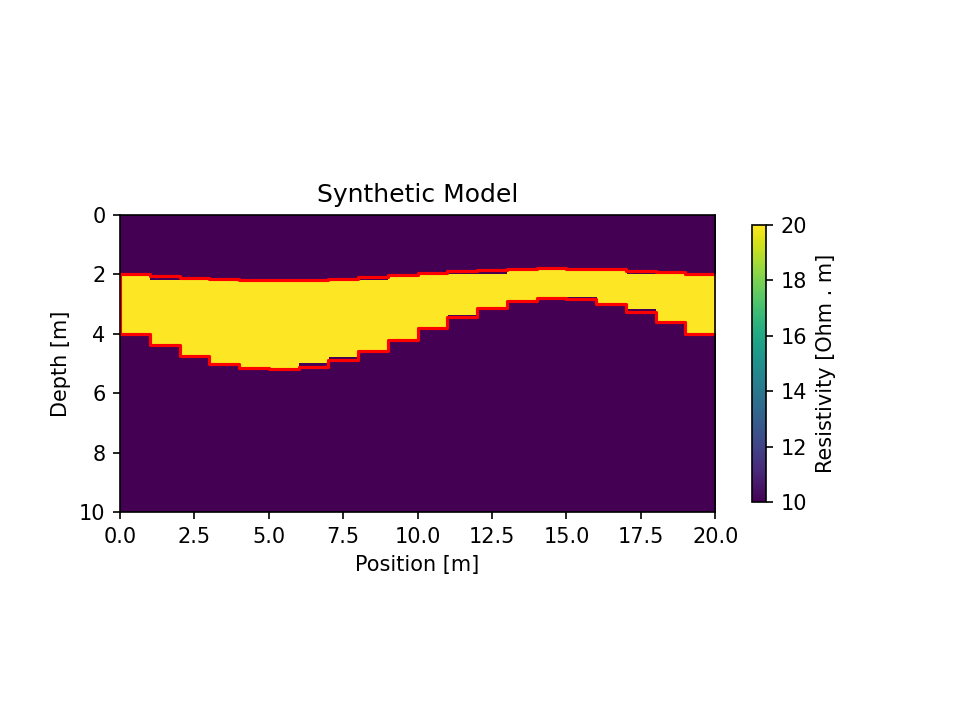

In [117]:
#Plot synthetic model

depth, resy = PlotResistivities(thk1, thk2, res, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')




In [118]:
# Parameters for initial model

res_ini = np.ones((npos, nlayer))*[12,15,18]
thk1_ini = np.ones(npos)*3
thk2_ini = np.ones(npos)*4


<IPython.core.display.Javascript object>


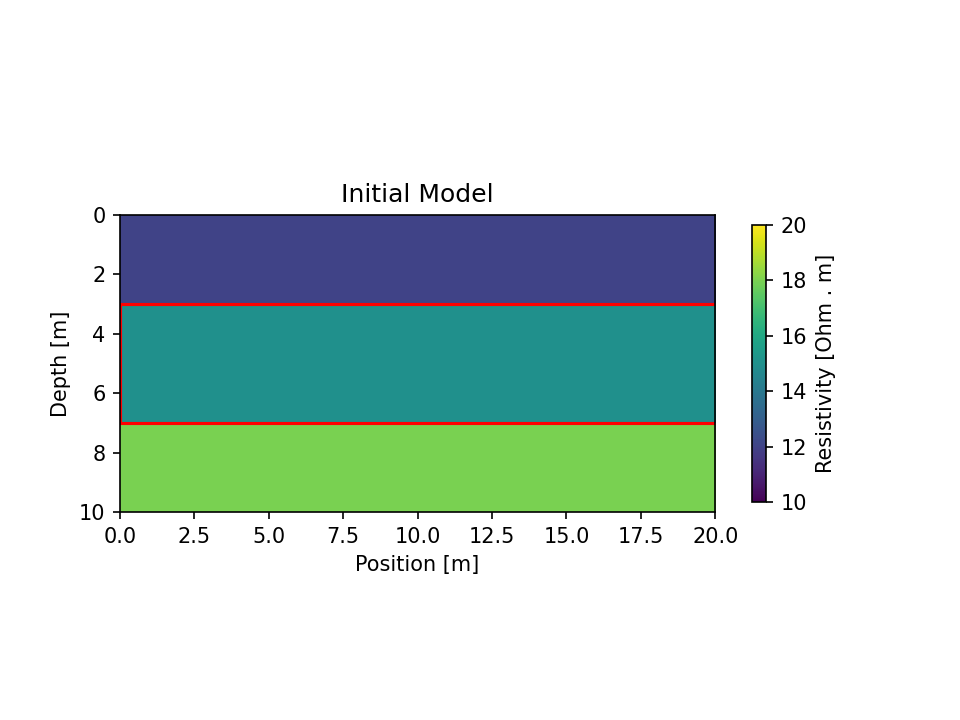

In [119]:
# Plot initial model

depth_ini, resy_ini = PlotResistivities(thk1_ini, thk2_ini, res_ini, npos, ny, 'Initial Model')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth_ini[0,1], depth_ini[:,1], depth_ini[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth_ini[0,1], depth_ini[:,2], depth_ini[-1,2])),'r')

In [124]:
# Define inversion transformations

transData = pg.trans.TransLin() # log transformation for data
transModel = pg.trans.TransLogLU(1,1000)  # log-transform ensures thk>0

# Create inversion

EMf = EMforward()
invEM = pg.Inversion()
invEM.setForwardOperator(EMf)

invEM.transModel = transModel
invEM.transData = transData


In [125]:
# Create empty array for true model
model = []

# Create empty array for true data 
data = []

for i in range(npos):
    model_i = np.array([thk1[i][0], thk2[i][0],  10, 20, 10]) # True model 
    model.append(model_i)
    data.append(EMf(model_i)) # creating data

# Relative error array
error = 1e-2 # introduce here the error you want to test
relativeError = np.ones_like(data[0]) * error

In [126]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):
    
    dataE = np.array(data[i]).copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invEM.run(dataE, relativeError, verbose=True, lam=1, maxIter=20)
    
    model_est_list.append(model_est)

# Model estimation array    
model_est_arr = np.array(model_est_list)

26/09/22 - 13:12:36 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:36 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66A00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.2e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 42.78 (dPhi = 83.84%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... 

26/09/22 - 13:12:37 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:37 - pyGIMLi - INFO - Starting inversion.


chi² = 20.2 (dPhi = 51.45%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 0.91 (dPhi = 90.35%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.91)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66400>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.2e-07/4.9e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 38.84 (dPhi = 72.55%) lam: 1
-----------------------------------------------------------------------------

26/09/22 - 13:12:38 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:38 - pyGIMLi - INFO - Starting inversion.


chi² = 0.86 (dPhi = 8.66%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.86)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66400>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.3e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 136.33 (dPhi = 54.33%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 36.87 (dPhi = 72.27%) lam: 1.0
----------------------------------------------------------------------------

26/09/22 - 13:12:39 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:39 - pyGIMLi - INFO - Starting inversion.


chi² = 0.69 (dPhi = 19.42%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.69)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A664C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.6e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 118.15 (dPhi = 56.24%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 56.17 (dPhi = 51.91%) lam: 1.0
---------------------------------------------------------------------------

26/09/22 - 13:12:40 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:40 - pyGIMLi - INFO - Starting inversion.


chi² = 1.73 (dPhi = 11.32%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 8 ... chi² = 1.4 (dPhi = 11.15%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 9 ... chi² = 1.4 (dPhi = 0.1%) lam: 1.0
################################################################################
#                 Abort criteria reached: dPhi = 0.1 (< 2.0%)                  #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66400>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.4e-07/4.9e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
i

26/09/22 - 13:12:40 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:40 - pyGIMLi - INFO - Starting inversion.


chi² = 0.85 (dPhi = 83.27%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.85)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A664C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.5e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 98.61 (dPhi = 61.99%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 32.45 (dPhi = 66.22%) lam: 1.0
----------------------------------------------------------------------------

26/09/22 - 13:12:41 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


chi² = 26.11 (dPhi = 18.99%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 12.09 (dPhi = 51.53%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² = 8.54 (dPhi = 26.82%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 7 ... chi² = 6.02 (dPhi = 25.91%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 8 ... chi² = 0.91 (dPhi = 71.02%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.91)                   #
################################################################################


26/09/22 - 13:12:41 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66A00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.5e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 133.73 (dPhi = 53.3%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... 

26/09/22 - 13:12:41 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


chi² = 41.15 (dPhi = 68.56%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 33.31 (dPhi = 18.63%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 16.01 (dPhi = 50.24%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² = 0.72 (dPhi = 89.02%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.72)                   #
################################################################################


26/09/22 - 13:12:41 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A664C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.4e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 130.54 (dPhi = 52.81%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... 

26/09/22 - 13:12:42 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


chi² = 57.41 (dPhi = 55.49%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 14.09 (dPhi = 74.05%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 5.2 (dPhi = 58.38%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² = 0.82 (dPhi = 68.92%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.82)                   #
################################################################################


26/09/22 - 13:12:42 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66A00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.3e-07/4.9e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 62.74 (dPhi = 48.69%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 9.39 (dPhi = 83.49%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.47 (dPhi = 75.49%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 1.3 (dPhi = 6.51%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6 ...

26/09/22 - 13:12:42 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:42 - pyGIMLi - INFO - Starting inversion.


chi² = 1.06 (dPhi = 9.56%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 7 ... chi² = 0.86 (dPhi = 8.32%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.86)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66400>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.4e-07/4.9e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 135.93 (dPhi = 52.65%) lam: 1
------------------------------------------------------------------------------

26/09/22 - 13:12:43 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:43 - pyGIMLi - INFO - Starting inversion.


chi² = 4.76 (dPhi = 90.91%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 1.1 (dPhi = 62.26%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² = 0.94 (dPhi = 6.95%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.94)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A664C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.2e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
------------------------------------------------------------------------------

26/09/22 - 13:12:43 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:43 - pyGIMLi - INFO - Starting inversion.


chi² = 0.94 (dPhi = 49.88%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.94)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A664C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.0e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

26/09/22 - 13:12:44 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


chi² = 6.1 (dPhi = 97.76%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 3.44 (dPhi = 37.41%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 0.64 (dPhi = 61.96%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.64)                   #
################################################################################


26/09/22 - 13:12:44 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66A00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.1e-07/4.9e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 5.91 (dPhi = 97.83%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... 

26/09/22 - 13:12:44 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:44 - pyGIMLi - INFO - Starting inversion.


chi² = 1.03 (dPhi = 70.27%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.01 (dPhi = 0.66%) lam: 1.0
################################################################################
#                 Abort criteria reached: dPhi = 0.66 (< 2.0%)                 #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A664C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.2e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 5.26 (dPhi = 98.12%) lam: 1
--------------------------------------------------------------------------------


26/09/22 - 13:12:45 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:45 - pyGIMLi - INFO - Starting inversion.


chi² = 1.05 (dPhi = 9.65%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 7 ... chi² = 0.92 (dPhi = 6.81%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.92)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66400>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.2e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 15.61 (dPhi = 94.97%) lam: 1
-------------------------------------------------------------------------------

26/09/22 - 13:12:46 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:46 - pyGIMLi - INFO - Starting inversion.


chi² = 1.37 (dPhi = 8.73%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 9 ... chi² = 1.12 (dPhi = 10.77%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 10 ... chi² = 0.86 (dPhi = 12.32%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.86)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66A00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.1e-07/4.9e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
----------------------------------------------------------------------------

26/09/22 - 13:12:47 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:47 - pyGIMLi - INFO - Starting inversion.


chi² = 0.52 (dPhi = 26.95%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.52)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66400>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.1e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 14.88 (dPhi = 95.3%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 3.64 (dPhi = 70.8%) lam: 1.0
-------------------------------------------------------------------------------

26/09/22 - 13:12:47 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:47 - pyGIMLi - INFO - Starting inversion.


chi² = 0.77 (dPhi = 27.99%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.77)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A664C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -4.9e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 6.12 (dPhi = 97.74%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... 

26/09/22 - 13:12:48 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:48 - pyGIMLi - INFO - Starting inversion.


chi² = 1.69 (dPhi = 62.02%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.66 (dPhi = 1.37%) lam: 1.0
################################################################################
#                 Abort criteria reached: dPhi = 1.37 (< 2.0%)                 #
################################################################################
fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66A00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.1e-07/4.9e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 46.22 (dPhi = 84.15%) lam: 1
--------------------------------------------------------------------------------

26/09/22 - 13:12:48 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
26/09/22 - 13:12:48 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.EMforward object at 0x00000179F19CD3B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000179E9A66A00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000179F19DF0E0>
min/max (data): -5.2e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 59.28 (dPhi = 77.86%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 4.7 (dPhi = 90.32%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 3.63 (dPhi = 18.77%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 0.87 (dPhi = 58.37%) lam: 1.0


################################################################################
#          

<IPython.core.display.Javascript object>


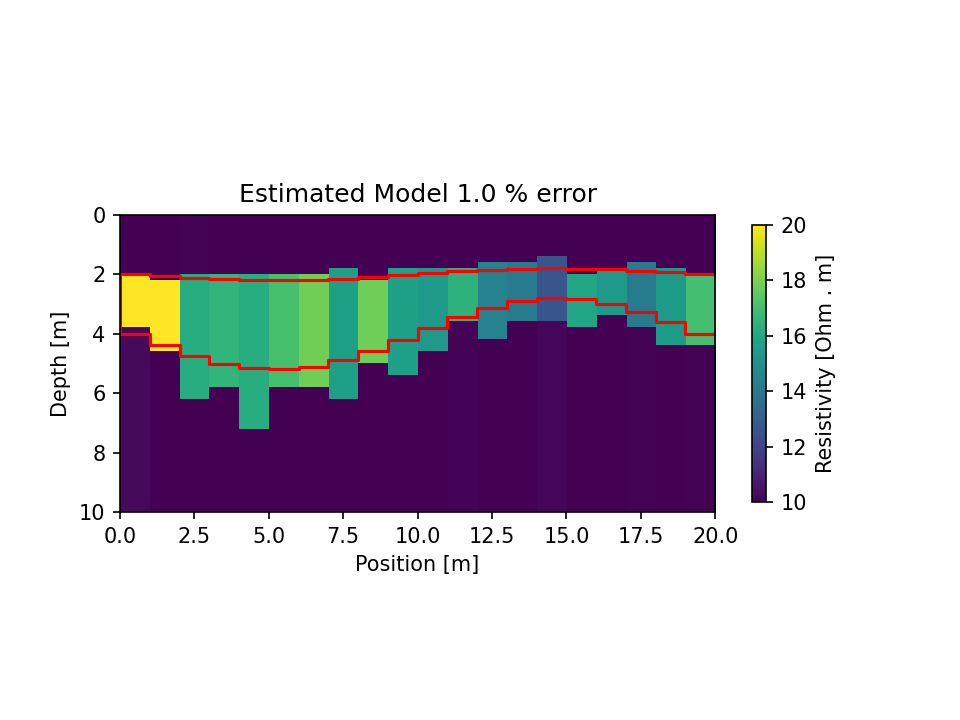

In [128]:
# Plot estimated model

depth_,resy_ = PlotResistivities(model_est_arr[:,0], model_est_arr[:,1], model_est_arr[:,2:] , npos, ny,
                                 'Estimated Model ' + str(error*100) + ' % error')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])), 'r')

